# 2. Inference of trained model for forest classification

-----


In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio as rio 

import os, wget

import numpy as np


from tqdm.notebook import tqdm
from joblib import dump, load
import enum 
import datetime as dt
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV


import os
import pandas as pd
import numpy as np
import rasterio as rio
from itertools import product
from rasterio import windows
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 3.1 Utils to compute spectral indices

In [ ]:
def NDVI(red: pd.Series, nir: pd.Series):
    ndvi = (nir - red) / ((nir + red).apply(lambda x: 0.000001 if x == 0 else x))
    return ndvi

def EVI(red: pd.Series, nir: pd.Series):
    evi2 = (
        2.5
        * (nir - red)
        / ((nir + 2.4 * red + 1).apply(lambda x: 0.000001 if x == 0 else x))
    )
    return evi2

def NDRE(red_far: pd.Series, nir: pd.Series):
    ndre = (nir - red_far) / (
        (nir + red_far).apply(lambda x: 0.000001 if x == 0 else x)
    )
    return ndre

def MSAVI(red: pd.Series, nir: pd.Series):
    msavi = (2 * nir + 1 - ((2 * nir + 1) ** 2 - 8 * (nir - red)) ** (1 / 2)) / 2
    return msavi


def FCI(red: pd.Series, nir: pd.Series):
    fci = np.sqrt(red * nir)
    return fci

def normalize_pixel(X: np.ndarray) -> np.ndarray:
        X = X / 10000
        X = np.clip(X, 0, 0.3)
        return X
    
        
def get_SVI(df: pd.DataFrame) -> pd.DataFrame:
    nir = df.loc[:, "B08"]
    red = df.loc[:, "B04"]
    red_far = df.loc[:, "B05"]
    df.loc[:, "NDVI"] = NDVI(red=red, nir=nir)
    df.loc[:, "NDRE"] = NDRE(red_far=red_far, nir=nir)
    df.loc[:, "MSAVI"] = MSAVI(red=red, nir=nir)
    df.loc[:, "EVI"] = EVI(red=red, nir=nir)
    df.loc[:, "FCI"] = FCI(red=red, nir=nir)
    return df


def get_tiles(ds, width=256, height=256):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

def get_dataset(x: np.ndarray)->pd.DataFrame:
    col_names = ["B01","B02","B03","B04",
            "B05","B06","B07","B08",
            "B8A","B09","B10","B11","B12"]
    bands = to_2d_array(x[:13, ...])    
    df = pd.DataFrame(bands.T, columns=col_names)
    df[col_names] = normalize_pixel(df.values)
    df = df.drop(columns='B10')
    df = get_SVI(df)
    terrain = to_2d_array(x[16:20, ...])
    df_terrain = pd.DataFrame(terrain.T, columns=["aspect", "slope", 
                                                      "wetnessindex", "sink"])
    mask = df_terrain['wetnessindex']<0
    df_terrain.loc[mask,'wetnessindex']=0
    texture = to_2d_array(x[20:32, ...])
    texture_columns = ["ASM1","ASM2",
                        "contrast1","contrast2",
                        "correlation1","correlation2",
                        "dissimilarity1","dissimilarity2",
                        "energy1","energy2",
                        "homogeneity1","homogeneity2"]

    df_texture = pd.DataFrame(texture.T, columns=texture_columns)
    forest_mask = to_2d_array(x[-1:, ...])
    df_forest = pd.DataFrame(forest_mask.T, columns=['forest_mask'])
    return pd.concat([df,df_terrain, df_texture, df_forest], axis=1)

def to_2d_array(x: np.ndarray)->np.ndarray:
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def save_tif_rasterio(
        raster_input: str, raster_output: str, values: np.ndarray, dtypes: rio.float32,  nodata: int = 0
    ):
        """
        Save numpy array to geotiff
        """
        with rio.open(raster_input, "r+") as src:
            kwargs = src.meta
            kwargs.update(dtype=dtypes, count=1, compress="lzw", nodata=nodata)
        with rio.open(raster_output, "w", **kwargs) as dst:
            dst.write_band(1, values.astype(dtypes))
            print(f"Saved geotiff: {raster_output}")

def get_scaled_data(path:str, cols_remove:list=['key', 'class']):
    df = pd.read_csv(path)
    mask = df['class']!=2
    df=df.loc[mask]
    x = df.drop(columns=cols_remove).values
    min_max_scaler = preprocessing.MinMaxScaler() 
    x_scaled = min_max_scaler.fit_transform(x)
    target_cols = [col for col in list(df.columns) if col not in cols_remove]
    df.loc[:, target_cols] = x_scaled
    return df, min_max_scaler

def get_calibrated(df:pd.DataFrame, model):
    clf = CalibratedClassifierCV(model) 
    df = df.sample(int(len(df)*0.7))
    y_train = df['class']
    x_train = df.drop(columns=['key', 'class'])
    clf.fit(x_train, y_train)
    return clf

In [1]:
# model_fname = models[model]['model']
# forest_model = load(model_fname)
# clf = get_calibrated(df=df_forest, model=forest_model)

In [ ]:

# Size ot tiles for classification
tile_width, tile_height = 512, 512

models = {'kNN':{'model': '../models/kNN_df1_filtered_modified.joblib',
                 'input_file': 'df1_filtered_modified.csv'},
          'XGB':{'model': '../models/XGB_df2_filtered_modified.joblib',
                 'input_file': 'df2_filtered_modified.csv'},
          'SVM':{'model': '../models/SVC_df5_filtered_modified.joblib',
                 'input_file': 'df5_filtered_modified.csv'},
          'RF':{'model': '../models/RandomForest_df3_filtered_modified.joblib',
                 'input_file': 'df3_filtered_modified.csv'}}


fname = '../rasters/dataset.tiff'
folder = '../shape_data/filtered_datasets_2024/'

for model in ['SVM']:
    model_fname = models[model]['model']
    forest_model = load(model_fname)
    df_scaled, min_max_scaler = get_scaled_data(os.path.join(folder, models[model]['input_file']))
    df_forest = df_scaled.loc[df_scaled['class']<10]
    if model=='SVM':
        forest_model = get_calibrated(df=df_forest, model=forest_model)
    le = LabelEncoder()
    le.fit_transform(df_forest['class'])
    with rio.open(fname, 'r+') as src:
        meta = src.meta.copy()
        output_mask = np.zeros(shape = (meta['height'], meta['width']))
        output_mask_proba = np.zeros(shape = (meta['height'], meta['width']))
        # Здесь можно добавить tqdm для отслеживания процесса
            
        for window, transform in tqdm(get_tiles(src, 
                                           width=tile_width,
                                           height=tile_height)):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            
            x = src.read(window=window)
            # get pixels for classification from tiff tile
            df = get_dataset(x)
            # vector to save results
            forecast=pd.Series(data=np.ones(shape=(len(df), 1)[0])*-1)
        
            mask_nan = df.iloc[:, :13].sum(axis=1)==0
            land_df = df.loc[~mask_nan]
            if len(land_df)!=0:
                land_df.iloc[:, :-1] = min_max_scaler.transform(land_df.iloc[:, :-1])
                
                forecast_mask = (land_df['forest_mask']==2)
                forecast.loc[~mask_nan] = (forecast_mask*1).values
        
                mask_forest = forecast==1
                land_df = land_df.drop(columns='forest_mask')
                forecast_probability = forecast.copy()
                if model=='XGB':
                    le = LabelEncoder()
                    le.fit_transform(df_forest['class'])
                    predictors_raw = forest_model.predict(land_df[forest_model.feature_names_in_].loc[mask_forest])
                    predictors = le.inverse_transform(predictors_raw)
                    forecast.loc[mask_forest] = predictors
                else:
                    forecast.loc[mask_forest] = forest_model.predict(land_df[forest_model.feature_names_in_].loc[mask_forest])
                if model=='SVM':
                    prob_predictions = np.max(forest_model.predict_proba(land_df[forest_model.feature_names_in_].loc[mask_forest]),
                                                                   axis=1)
                    forecast_probability.loc[mask_forest] = prob_predictions
                else:
                    forecast_probability.loc[mask_forest] = np.max(forest_model.predict_proba(land_df[forest_model.feature_names_in_].loc[mask_forest]),
                                                                   axis=1)
            else:
                forecast_probability = forecast.copy()
            forest_tile = forecast.values.reshape(meta['height'], meta['width'])
            forest_tile[forest_tile<0]=0
            ranges = window.toranges()
            output_mask[ranges[0][0]:ranges[0][1],ranges[1][0]:ranges[1][1]] = forest_tile
            forecast_probability[forecast_probability<=0] = -1.
            forest_tile_proba = forecast_probability.values.reshape(meta['height'], meta['width'])
            output_mask_proba[ranges[0][0]:ranges[0][1],ranges[1][0]:ranges[1][1]] = forest_tile_proba
            
    raster_input = fname
    raster_output = f'../rasters/prediction_{model}.tif'
    save_tif_rasterio(raster_input=raster_input, raster_output=raster_output, values=output_mask,  dtypes=rio.int16, nodata=0)
    
    raster_input = fname
    raster_output = f'../rasters/prediction_{model}_UQ.tif'
    save_tif_rasterio(raster_input=raster_input, raster_output=raster_output, values=output_mask_proba, dtypes=rio.float32,  
                      nodata=np.min(forest_tile_proba))

0it [00:00, ?it/s]

Saved geotiff: ../rasters/prediction_bratsk_2024_SVM.tif
Saved geotiff: ../rasters/prediction_bratsk_2024_SVM_UQ.tif


<matplotlib.image.AxesImage>

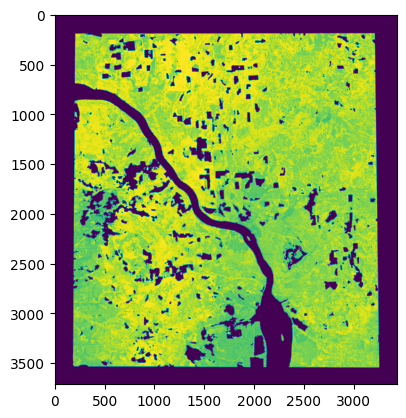

In [ ]:
plt.imshow(output_mask_proba)

End